## Neural Networks Model

In [1]:
class Layers:

    def __init__(self, activation_function_forward, activation_function_backward, count_output_neuron, no_of_inputs, seed):
        self.activation_function_forward = activation_function_forward      # the forward activation function
        self.activation_function_backward = activation_function_backward    # the corresponding backward activation function
        self.count_output_neuron = count_output_neuron                  # taking the number of output neurons as a paramter
        self.no_of_inputs = no_of_inputs                                # taking the number of inputs for a given layer
        #self.X_train = X_train                                          # Training data X
        self.seed = seed                                        # seed parameter
        np.random.rand(seed)    # seed is used to maintain the same set of random values generated elsewhere in the class


        self.W = np.random.rand(no_of_inputs, count_output_neuron)
        self.bias = np.random.rand(count_output_neuron)


    def updateWeightGradient(self, dW, alpha):      # updating weights of the current layer to pass for the next layer
        self.W = self.W - alpha * dW

    def updateBiasGradient(self, dbias, alpha):     # updating bias of the current layer to pass for the next layer
        self.bias = self.bias - alpha * dbias


    # activate function which takes X as input and returns after activation function is called on (WX + B) matrix
    def activate(self, curr_input):
        self.curr_input = curr_input
        N = np.matmul(curr_input, self.W)
        P = N + self.bias

        self.curr_output = self.activation_function_forward(P)
        return self.curr_output
    

In [2]:
class NeuralNetwork:
    def __init__(self, list_of_layers, loss, seed):
        self.list_of_layers = list_of_layers        # list of layers objects
        self.loss = loss                # loss object
        self.seed = seed
        np.random.seed(seed)


    # In the forward pass of neural network, we pass through all the layers such that output of current layer is the input for the next layer.
    # Finally, we return the output of the last layer
    def forward(self, X):
        curr_input = X
        for curr_layer in self.list_of_layers:
            next_input = curr_layer.activate(curr_input)
            curr_input = next_input

        output = curr_input

        output = np.array(output)
        return output

    # In the backward pass, we calcuate the error generated and also reverse traverse the layers and calculate the effect of loss w.r.t input X
    def backward(self, X, y_true, alpha):
        output = self.forward(X)

        error = self.loss.lossLayer_forward(output, y_true)   # calculating loss in forward pass
        dL_dA = self.loss.lossLayer_backward(output, y_true)    # calculating loss in backward pass

        weights = []    # store the weights of each layer so as to calculate optimal weights
        bias = []       # store the bias of each layer so as to calculate optimal bias

        for curr_layer in reversed(self.list_of_layers):

            dL_dP = curr_layer.activation_function_backward(curr_layer.curr_output, dL_dA)

            curr_layer.curr_input = np.array(curr_layer.curr_input)

            dW = np.matmul(curr_layer.curr_input.T, dL_dP)  # taking transpose
            dbias = np.sum(dL_dP)

            weights.append(curr_layer.W)
            bias.append(curr_layer.bias)

            curr_layer.updateWeightGradient(dW, alpha)
            curr_layer.updateBiasGradient(dbias, alpha)

            dL_dX = np.matmul(dL_dP, curr_layer.W.T)
            dL_dA = dL_dX
        return error,bias,weights

        # In this fucntion, we perform the entire procedure for several number of iterations and finally return error, weights, bias
    def SGD(self, X_train, y_train, X_test, y_test, loss):  # Stochastic Gradient Descent Algorithm
        arr = []
        iter = 10000
        graph_X = []
        graph_Y = []
        for i in range(iter):
            temp = []
            error,bias,weights = self.backward(X_train, Y_train, 0.001)
            #print('Error = ',error)
            temp.append(error)
            temp.append(bias)
            temp.append(weights)
            arr.append(temp)
            graph_X.append(i)
            graph_Y.append(error)
            if i % 1000 == 0:

                print(f'Error at iteration {i}: {error}')

        # Evaluate

        return arr,graph_X,graph_Y

In [3]:
# This is mean square error class that calculates error in both forward and backward passes
class mean_square_error:

    def lossLayer_forward(self,P,Y):
        return np.mean((P - Y.reshape(-1, 1)) ** 2)

    def lossLayer_backward(self,P,Y): #sizes of both P and Y  = nx1

        nSamples = len(Y)
        dL_dA = np.zeros((nSamples,1))
        for i in range(nSamples):
            dL_dA[i][0] = (2*(P[i][0] - Y[i])) / nSamples

        return dL_dA  # returning dL/dP

        #return P-Y

In [4]:
class cross_entropy_loss:
    def lossLayer_forward(self,P,Y):
        P = np.exp(P)
        P /= np.sum(P, axis=-1, keepdims=True)
        loss = -np.sum(Y * np.log(P))
        return loss

    def lossLayer_backward(self,P,Y):    #sizes of both P and Y  = nxc
        P = np.exp(P)
        #output -= np.max(output, axis=-1, keepdims=True)[0][0]
        P /= np.sum(P, axis=-1, keepdims=True)
        return P - Y

In [5]:
# Implementations of several activation functions in both forward and backward passes

def linear_forward(P):
    return P

def linear_backward(P, dL_dA):
    shape = P.shape
    return dL_dA * np.ones(shape)


def sigmoid_forward(x):
        ans = 1 / (1 + np.exp(-x))
        return ans

def sigmoidLayer_forward(P):
    ans=[]
    for i in P:
        new = sigmoid_forward(i)
        ans.append(new)
    return ans

def sigmoidLayer_backward(P, dL_dA):
        dL_dP = []
        index = 0
        for i in P:
            new = sigmoid_forward(i)
            dL_dP.append(dL_dA[index] * (new * (1 - new)))  # dL/dP = dL/dA * sigmoid(P) * (1 - sigmoid(P))
            index += 1
        dL_dP = np.array(dL_dP)
        return dL_dP
def tanhLayer_forward(P):
    return np.tanh(P)
    '''
    ans=[]
    for i in P:
        new = tanh_forward(i)
        ans.append(new)
    return ans
    '''

def tanhLayer_backward(P, dL_dA):
    return dL_dA * (1 - np.tanh(P) ** 2)

    '''
    dL_dP = []
    index = 0
    for i in P:
        new = tanh_forward(2*i)  # i don't think this is correct
        dL_dP.append(dL_dA[index] * 4 * (1 - new))
        index += 1
    dL_dP = np.array(dL_dP)
    return dL_dP
    '''

In [6]:
# Calculating the accuracy of the model


def test_model(list_of_layers, X_test, Y_test, threshold):
    accuracy = 0
    curr_X = X_test

    for i in range(len(Y_test)):
        N = np.matmul(curr_X[i], opt_weights[0])
        P = N + opt_bias[0]
        for j in range(len(list_of_layers)):
            output = list_of_layers[j].activation_function_forward(P)
            P = output

        if(abs(output[0] - Y_test[i]) <= threshold):
            accuracy += 1

    print("Accuracy =",100.0*accuracy/len(Y_test), "%")

### Running the model on the California dataset


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
california = fetch_california_housing()

In [8]:
X = california.data
print(X.shape)

Y = california.target
print(Y.shape)

(20640, 8)
(20640,)


Just one output neural with linear activation and least mean square loss. (This is linear regression).

Error at iteration 0: 3.291508525599838
Error at iteration 1000: 0.6961741158766115
Error at iteration 2000: 0.596254579563981
Error at iteration 3000: 0.541027721881347
Error at iteration 4000: 0.5013777714438358
Error at iteration 5000: 0.47227916920844526
Error at iteration 6000: 0.45083603140875955
Error at iteration 7000: 0.43499272213132995
Error at iteration 8000: 0.4232551370935085
Error at iteration 9000: 0.4145336133368976
min error =  0.4080378922291242
Mean Squared Error: 1.5329478531347929


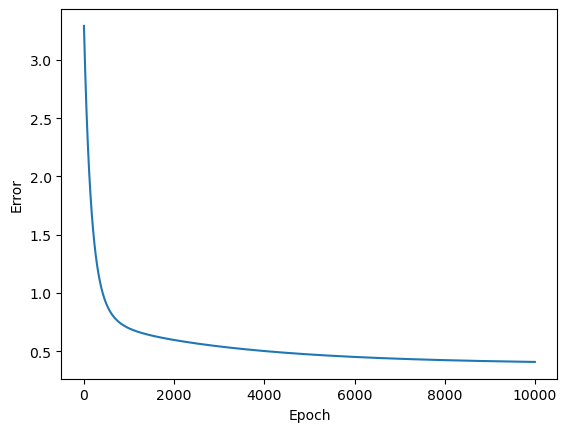

In [10]:
# Normalizing the data
X = (X - np.mean(X, axis = 0)) / (np.std(X, axis = 0))
Y = (Y - np.mean(Y, axis = 0)) / (np.std(Y, axis = 0))

# Spliting the data with 85% into training and 15% into testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state = 30)

#print(Y_test.shape)
seed = 21

layer1 = Layers(linear_forward, linear_backward, 1, X_train.shape[1], seed)   # creating layers object
list_of_layers = [layer1]   # creating layers list

loss_obj = mean_square_error()  # creating loss object

NN_obj = NeuralNetwork(list_of_layers, loss_obj, seed)  # creating neural networks object


J, graph_X, graph_Y = NN_obj.SGD(X_train, Y_train, X_test, Y_test, loss_obj)    # calling SGD function in NeuralNetwork class
min_error = 1000000000

# Calculating the min error among the total samples
for i in range(len(J)):
    if(J[i][0] <= min_error):
      #optimum
        opt_weights = J[i][2]
        opt_bias = J[i][1]
        min_error = J[i][0]

print("min error = ",min_error)

Y_pred = NN_obj.forward(X_test)
mean_sqr_error = loss_obj.lossLayer_forward(Y_test, Y_pred)
print("Mean Squared Error:", mean_sqr_error)

plt.plot(graph_X, graph_Y)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

In [11]:
from sklearn.metrics import r2_score
y_pred = NN_obj.forward(X_test)
r_squared = r2_score(Y_test, y_pred)
print(f'R-squared value: {r_squared}')

R-squared value: 0.5612339918594368


In [12]:
# Testing the accuracy of the model
test_model(list_of_layers, X_test, Y_test, 1)

Accuracy = 89.98708010335918 %


Two layers. Layer 1 with 13 output neurons with sigmoid activation. Layer 2 with one output neuron and linear activation. use mean squared loss

Error at iteration 0: 19.831775140060678
Error at iteration 1000: 0.7830524815857421
Error at iteration 2000: 0.6816054571844828
Error at iteration 3000: 0.6105934655214222
Error at iteration 4000: 0.5599956627502964
Error at iteration 5000: 0.5244518464261341
Error at iteration 6000: 0.499774197013099
Error at iteration 7000: 0.4824574671692215
Error at iteration 8000: 0.4698716478775235
Error at iteration 9000: 0.46027363549257766
min error =  0.4526088814812856
Mean Squared Error: 1.5321660123404486


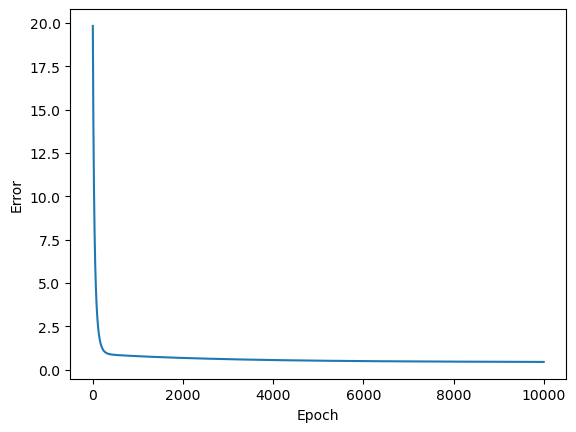

In [9]:
# Normalizing the data
X = (X - np.mean(X, axis = 0)) / (np.std(X, axis = 0))
Y = (Y - np.mean(Y, axis = 0)) / (np.std(Y, axis = 0))

# Spliting the data with 85% into training and 15% into testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state = 30)

#print(Y_test.shape)
seed = 21

layer1 = Layers(sigmoidLayer_forward, sigmoidLayer_backward, 13, X_train.shape[1], seed)   # creating layers object
layer2 = Layers(linear_forward, linear_backward, 1, 13, seed)   # creating layers object
list_of_layers = [layer1, layer2]   # creating layers list

loss_obj = mean_square_error()  # creating loss object

NN_obj = NeuralNetwork(list_of_layers, loss_obj, seed)  # creating neural networks object


J, graph_X, graph_Y = NN_obj.SGD(X_train, Y_train, X_test, Y_test, loss_obj)    # calling SGD function in NeuralNetwork class
min_error = 1000000000

# Calculating the min error among the total samples
for i in range(len(J)):
    if(J[i][0] <= min_error):
      #optimum
        opt_weights = J[i][2]
        opt_bias = J[i][1]
        min_error = J[i][0]
print("min error = ",min_error)

Y_pred = NN_obj.forward(X_test)
mean_sqr_error = loss_obj.lossLayer_forward(Y_test, Y_pred)
print("Mean Squared Error:", mean_sqr_error)

plt.plot(graph_X, graph_Y)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()

Error at iteration 0: 66.99912691836009
Error at iteration 1000: 0.9700726660488248
Error at iteration 2000: 0.9665550445129524
Error at iteration 3000: 0.9630704086233826
Error at iteration 4000: 0.9594317869388951
Error at iteration 5000: 0.9554473130976114
Error at iteration 6000: 0.9509092431591707
Error at iteration 7000: 0.9455823168453765
Error at iteration 8000: 0.9391906639447001
Error at iteration 9000: 0.9314028630320218
min error =  0.9218264588537818
Mean Squared Error: 1.0485937938326297


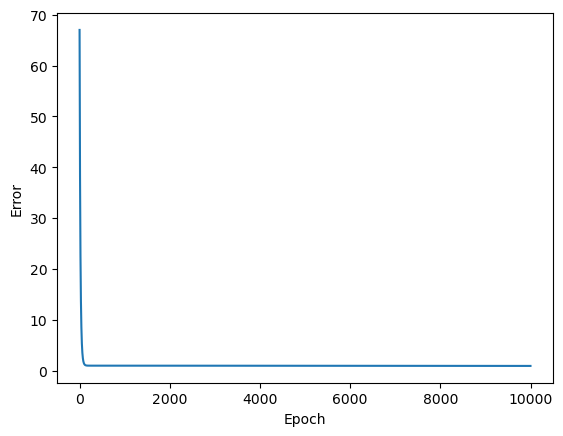

In [11]:
# Normalizing the data
X = (X - np.mean(X, axis = 0)) / (np.std(X, axis = 0))
Y = (Y - np.mean(Y, axis = 0)) / (np.std(Y, axis = 0))

# Spliting the data with 85% into training and 15% into testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state = 30)

#print(Y_test.shape)
seed = 21

layer1 = Layers(sigmoidLayer_forward, sigmoidLayer_backward, 13, X_train.shape[1], seed)   # creating layers object
layer2 = Layers(sigmoidLayer_forward, sigmoidLayer_backward, 13, 13, seed)   # creating layers object
layer3 = Layers(linear_forward, linear_backward, 1, 13, seed)   # creating layers object
list_of_layers = [layer1, layer2, layer3]

loss_obj = mean_square_error()  # creating loss object

NN_obj = NeuralNetwork(list_of_layers, loss_obj, seed)  # creating neural networks object


J, graph_X, graph_Y = NN_obj.SGD(X_train, Y_train, X_test, Y_test, loss_obj)    # calling SGD function in NeuralNetwork class
min_error = 1000000000

# Calculating the min error among the total samples
for i in range(len(J)):
    if(J[i][0] <= min_error):
        opt_weights = J[i][2]
        opt_bias = J[i][1]
        min_error = J[i][0]

print("min error = ",min_error)

Y_pred = NN_obj.forward(X_test)
mean_sqr_error = loss_obj.lossLayer_forward(Y_test, Y_pred)
print("Mean Squared Error:", mean_sqr_error)

plt.plot(graph_X, graph_Y)
plt.xlabel("Epoch")
plt.ylabel("Error")
plt.show()